# Tải spark và thiết lập môi trường

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!tar xf spark-3.4.1-bin-hadoop3.tgz


In [ ]:
!pip install -q findspark

In [ ]:
# Thiết lập biến môi trường
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

In [ ]:
import findspark
findspark.init("/content/spark-3.4.1-bin-hadoop3")

# Khởi tạo và đọc cấu trúc dữ liệu Join nó vào

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("RestaurantReview") \
    .getOrCreate()

In [ ]:
review_sentiment = spark.read.csv("/content/drive/MyDrive/Big_Data/Tiểu luận/model/file-csv/phan-tich-cam-xuc.csv", header=True, inferSchema=True)  # Phân tích cảm xúc
restaurant_info = spark.read.csv("/content/drive/MyDrive/Big_Data/Tiểu luận/model/file-csv/restaurant_review.csv", header=True, inferSchema=True)  # Thông tin nhà hàng
restaurant_ratings = spark.read.csv("/content/drive/MyDrive/Big_Data/Tiểu luận/model/file-csv/tinhdiemnhahang.csv", header=True, inferSchema=True)  # Rating nhà hàng

# Kiểm tra cấu trúc dữ liệu của từng file
review_sentiment.printSchema()
restaurant_info.printSchema()
restaurant_ratings.printSchema()

root
 |-- review_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- review_text: string (nullable = true)
 |-- review_date: date (nullable = true)
 |-- restaurant_id: integer (nullable = true)

root
 |-- restaurant_id: double (nullable = true)
 |-- restaurant_name: string (nullable = true)
 |-- street: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- district: string (nullable = true)
 |-- city: string (nullable = true)

root
 |-- review_id: integer (nullable = true)
 |-- restaurant_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- review_text: string (nullable = true)
 |-- food_quality: integer (nullable = true)
 |-- service_quality: integer (nullable = true)
 |-- ambiance_quality: integer (nullable = true)



In [ ]:
combined_data = review_sentiment.join(restaurant_info, "restaurant_id").join(restaurant_ratings, "restaurant_id")

# Sắp xếp kết quả theo thứ tự tăng dần của restaurant_id
a = combined_data.orderBy("restaurant_id", ascending=True)

# Hiển thị một vài dòng dữ liệu kết quả sau khi join
a.show(30)

+-------------+---------+-------+------+--------------------+-----------+--------------------+--------------------+-------------+---------------+----+---------+-------+--------------------+------------+---------------+----------------+
|restaurant_id|review_id|user_id|rating|         review_text|review_date|     restaurant_name|              street|         ward|       district|city|review_id|user_id|         review_text|food_quality|service_quality|ambiance_quality|
+-------------+---------+-------+------+--------------------+-----------+--------------------+--------------------+-------------+---------------+----+---------+-------+--------------------+------------+---------------+----------------+
|            1|      171|    671|     3|Không tệ nhưng cũ...| 2024-06-30|bun_ca_loc_kien_g...|53 Bùi Đình Túy, ...|           24|quan_binh_thanh| hcm|      484|     81|Quán ăn xuất sắc,...|           5|              5|               3|
|            1|      584|    429|     5|Chất lượng tuyệt

In [ ]:
#Muốn dừng spark thì chạy
spark.stop()

# Đánh giá nhà hàng dựa vào bình luận và rating

In [ ]:
!pip install pyspark==3.4.1 spark-nlp==5.4.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 579.5/579.5 kB 15.2 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285391 sha256=f0b790ec03a48646c0853ed3497dab5cc68dd4c3b3013677b79ae34076279234
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


## Sử dụng spark nlp ptich bình luận

In [ ]:
!pip install spark-nlp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 579.5/579.5 kB 17.6 MB/s eta 0:00:00


In [ ]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

# Khởi tạo Spark NLP
spark = sparknlp.start()

# Nạp dữ liệu đã kết hợp
combined_data = spark.read.csv("/content/drive/MyDrive/Big_Data/Tiểu luận/model/file-csv/phan-tich-cam-xuc.csv", header=True, inferSchema=True)

# Tiền xử lý văn bản: Tokenize và xử lý văn bản
document_assembler = DocumentAssembler() \
    .setInputCol("review_text") \
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

# Sử dụng mô hình phân tích cảm xúc Vivekn
sentiment_detector = ViveknSentimentModel.pretrained() \
    .setInputCols(["document", "token"]) \
    .setOutputCol("sentiment")

# Tạo pipeline Spark NLP
pipeline = Pipeline(stages=[
    document_assembler,
    tokenizer,
    sentiment_detector
])

# Áp dụng pipeline vào dữ liệu
model = pipeline.fit(combined_data)
result = model.transform(combined_data)

# Sắp xếp kết quả theo thứ tự tăng dần của restaurant_id
phan_tich_cam_xuc = result.orderBy("restaurant_id", ascending=True)

# Hiển thị kết quả
phan_tich_cam_xuc.select("restaurant_id", "review_id",  "user_id", "review_text", "sentiment.result").show(truncate=False)


sentiment_vivekn download started this may take some time.
Approximate size to download 873.6 KB
[OK!]
+-------------+---------+-------+------------------------------------------------+----------+
|restaurant_id|review_id|user_id|review_text                                     |result    |
+-------------+---------+-------+------------------------------------------------+----------+
|1            |893      |1326   |Mọi thứ ổn, không có gì đặc biệt.               |[negative]|
|1            |171      |671    |Không tệ nhưng cũng không quá tốt.              |[negative]|
|1            |584      |429    |Chất lượng tuyệt đỉnh, không chê vào đâu được.  |[negative]|
|1            |201      |1327   |Trải nghiệm vừa phải, không có gì đáng nhớ.     |[negative]|
|1            |957      |1327   |Trải nghiệm khá ổn, hài lòng.                   |[negative]|
|1            |123      |1670   |Quán ăn xuất sắc, đồ ăn ngon và phục vụ chu đáo.|[negative]|
|2            |369      |1329   |Quán ăn xuất sắc, 

### DO KẾT QUẢ PHÂN LOẠI DỰA VÀO SPARKNLP KÉM NÊN EM SẼ TẠO THÊM TỪ ĐIỂN CẢM XÚC ĐỂ MÁY PHÂN LOẠI TỐT HƠN

In [ ]:
# Tạo từ điển cảm xúc
negative_words = [
    "tồi", "tệ", "không muốn quay lại", "kém", "không đáng giá",
    "thất vọng", "không ngon", "chờ đợi lâu", "không hài lòng",
    "không tốt", "chán", "tạm", "thấp"
]

positive_words = [
    "tốt", "ngon", "sẽ quay lại", "hài lòng", "đáo", "hợp lí", "dễ"
    "tuyệt vời", "hoàn hảo", "tuyệt", "xuất sắc", "tuyệt vời", "ổn"

]



In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Hàm phân loại cảm xúc dựa trên từ điển
def classify_sentiment(text):
    if any(word in text for word in negative_words):
        return "Negative"
    elif any(word in text for word in positive_words):
        return "Positive"
    else:
        return "Neutral"

# Đăng ký UDF với Spark
classify_sentiment_udf = udf(classify_sentiment, StringType())


In [ ]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# Khởi tạo Spark NLP
spark = sparknlp.start()

# Nạp dữ liệu đã kết hợp
combined_data = spark.read.csv("/content/drive/MyDrive/Big_Data/Tiểu luận/model/file-csv/phan-tich-cam-xuc.csv", header=True, inferSchema=True)

# Tiền xử lý văn bản: Tokenize và xử lý văn bản
document_assembler = DocumentAssembler() \
    .setInputCol("review_text") \
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

# Sử dụng mô hình phân tích cảm xúc Vivekn
sentiment_detector = ViveknSentimentModel.pretrained() \
    .setInputCols(["document", "token"]) \
    .setOutputCol("sentiment")

# Tạo UDF để phân loại cảm xúc
classify_sentiment_udf = udf(classify_sentiment, StringType())

# Tạo pipeline Spark NLP
pipeline = Pipeline(stages=[
    document_assembler,
    tokenizer,
    sentiment_detector
])

# Áp dụng pipeline vào dữ liệu
model = pipeline.fit(combined_data)
result = model.transform(combined_data)

# Áp dụng UDF để phân loại cảm xúc dựa trên từ điển
result_with_custom_sentiment = result.withColumn("ket_qua_khi_co_tu_dien", classify_sentiment_udf(col("review_text")))

# Sắp xếp kết quả theo thứ tự tăng dần của restaurant_id
phan_tich_cam_xuc = result_with_custom_sentiment.orderBy("restaurant_id", ascending=True)

# Hiển thị kết quả
phan_tich_cam_xuc.select("restaurant_id", "review_id", "user_id", "review_text", "sentiment.result", "ket_qua_khi_co_tu_dien").show(truncate=False)


sentiment_vivekn download started this may take some time.
Approximate size to download 873.6 KB
[OK!]
+-------------+---------+-------+------------------------------------------------+----------+----------------------+
|restaurant_id|review_id|user_id|review_text                                     |result    |ket_qua_khi_co_tu_dien|
+-------------+---------+-------+------------------------------------------------+----------+----------------------+
|1            |893      |1326   |Mọi thứ ổn, không có gì đặc biệt.               |[negative]|Positive              |
|1            |171      |671    |Không tệ nhưng cũng không quá tốt.              |[negative]|Negative              |
|1            |584      |429    |Chất lượng tuyệt đỉnh, không chê vào đâu được.  |[negative]|Positive              |
|1            |201      |1327   |Trải nghiệm vừa phải, không có gì đáng nhớ.     |[negative]|Neutral               |
|1            |957      |1327   |Trải nghiệm khá ổn, hài lòng.                

### kiem tra

In [ ]:
# kết quả của model khi có từ điển
a = '{:-^50}'.format('kết quả khi thêm từ điển')
print(a)
result_with_custom_sentiment.groupBy("ket_qua_khi_co_tu_dien").count().show()

#kết quả khi không có
b = '{:-^50}'.format('kết quả khi không có từ điển')
print(b)
result.groupBy("sentiment.result").count().show()


-------------kết quả khi thêm từ điển-------------
+----------------------+-----+
|ket_qua_khi_co_tu_dien|count|
+----------------------+-----+
|              Positive| 2650|
|               Neutral|  938|
|              Negative| 2370|
+----------------------+-----+

-----------kết quả khi không có từ điển-----------
+----------+-----+
|    result|count|
+----------+-----+
|[positive]|  713|
|[negative]| 5245|
+----------+-----+



### đánh giá nhà hàng dựa vào comment


In [ ]:
from pyspark.sql.functions import col, udf, when, max as sql_max
from pyspark.sql.types import StringType

# Tạo UDF để ánh xạ cảm xúc thành nhãn đánh giá
def map_sentiment_to_label(sentiment):
    if sentiment == "Positive":
        return "Ngon"
    elif sentiment == "Neutral":
        return "Bình thường"
    elif sentiment == "Negative":
        return "Dở"
    else:
        return "Chưa xác định"

map_sentiment_udf = udf(map_sentiment_to_label, StringType())

# Áp dụng UDF để tạo cột đánh giá
result_with_labels = result_with_custom_sentiment.withColumn("rating_label", map_sentiment_udf(col("ket_qua_khi_co_tu_dien")))

# Nhóm theo restaurant_id và cảm xúc, đếm số lượng các cảm xúc
grouped_result = result_with_labels.groupBy("restaurant_id", "rating_label").count()

# Tìm cảm xúc xuất hiện nhiều nhất cho từng restaurant_id
from pyspark.sql.window import Window

# Sắp xếp theo số lượng giảm dần trong mỗi nhóm restaurant_id
window_spec = Window.partitionBy("restaurant_id").orderBy(col("count").desc())

# Chọn cảm xúc xuất hiện nhiều nhất
most_frequent_sentiment = grouped_result.withColumn("rank", sql_max("count").over(window_spec)) \
    .filter(col("count") == col("rank")) \
    .select("restaurant_id", "rating_label")

# Hiển thị kết quả
most_frequent_sentiment.show()

+-------------+------------+
|restaurant_id|rating_label|
+-------------+------------+
|            1|        Ngon|
|            2|        Ngon|
|            3|          Dở|
|            3| Bình thường|
|            3|        Ngon|
|            4| Bình thường|
|            5|        Ngon|
|            6|          Dở|
|            7|          Dở|
|            8|          Dở|
|            9|        Ngon|
|           10|        Ngon|
|           11|        Ngon|
|           12|        Ngon|
|           13|          Dở|
|           13| Bình thường|
|           13|        Ngon|
|           14|        Ngon|
|           15|          Dở|
|           16|          Dở|
+-------------+------------+
only showing top 20 rows



## Dựa vào sentiment_score(được tạo ra từ rating) để phân tích cảm xúc-> đánh giá nhà hàng dựa vào sentiment_score

In [ ]:
import pandas as pd
import random

# Đọc tệp CSV
file_path = '/content/drive/MyDrive/Big_Data/Tiểu luận/model/file-csv/phan-tich-cam-xuc.csv'
df = pd.read_csv(file_path)

# Sentiment score ranges based on the rating
sentiment_ranges = {
    1: (-1, -0.6),
    2: (-0.6, -0.2),
    3: (-0.2, 0.2),
    4: (0.2, 0.6),
    5: (0.6, 1)
}

# Thêm cột sentiment_score vào DataFrame
def calculate_sentiment_score(rating):
    if rating in sentiment_ranges:
        return round(random.uniform(*sentiment_ranges[rating]), 2)
    return None

df['sentiment_score'] = df['rating'].apply(calculate_sentiment_score)

# Lưu DataFrame vào tệp CSV mới
output_path = '/content/phan-tich-cam-xuc_updated.csv'
df.to_csv(output_path, index=False)

output_path


'/content/phan-tich-cam-xuc_updated.csv'

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

# Khởi tạo SparkSession
spark = SparkSession.builder.appName("SentimentClassification").getOrCreate()

# Đọc dữ liệu từ tệp CSV
file_path = '/content/phan-tich-cam-xuc_updated.csv'
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Phân loại cảm xúc dựa trên sentiment_score
classified_data = data.withColumn(
    "ý_nghĩa_đánh_giá",
    when(col("sentiment_score").between(-1, -0.6), "đánh giá tiêu cực")
    .when(col("sentiment_score").between(-0.6, -0.2), "đánh giá góp ý")
    .when(col("sentiment_score").between(-0.2, 0.2), "đánh giá trung lập")
    .when(col("sentiment_score").between(0.2, 0.6), "đánh giá tích cực")
    .otherwise("đánh giá tốt")
)

# Sắp xếp kết quả theo thứ tự tăng dần của restaurant_id
phan_tich_cam_xuc = classified_data.orderBy("restaurant_id", ascending=True)

# Hiển thị kết quả
phan_tich_cam_xuc.select("restaurant_id", "review_id", "user_id", "review_text", "sentiment_score", "ý_nghĩa_đánh_giá").show(truncate=False)

+-------------+---------+-------+------------------------------------------------+---------------+------------------+
|restaurant_id|review_id|user_id|review_text                                     |sentiment_score|ý_nghĩa_đánh_giá  |
+-------------+---------+-------+------------------------------------------------+---------------+------------------+
|1            |893      |1326   |Mọi thứ ổn, không có gì đặc biệt.               |-0.07          |đánh giá trung lập|
|1            |171      |671    |Không tệ nhưng cũng không quá tốt.              |-0.17          |đánh giá trung lập|
|1            |584      |429    |Chất lượng tuyệt đỉnh, không chê vào đâu được.  |0.83           |đánh giá tốt      |
|1            |201      |1327   |Trải nghiệm vừa phải, không có gì đáng nhớ.     |0.12           |đánh giá trung lập|
|1            |957      |1327   |Trải nghiệm khá ổn, hài lòng.                   |0.44           |đánh giá tích cực |
|1            |123      |1670   |Quán ăn xuất sắc, đồ ăn

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, udf
from pyspark.sql.types import StringType

# Tạo session Spark
spark = SparkSession.builder.appName("RestaurantRating").getOrCreate()

# Đọc dữ liệu (cập nhật đường dẫn của bạn)
data = spark.read.csv("/content/phan-tich-cam-xuc_updated.csv", header=True, inferSchema=True)

# Tính điểm trung bình sentiment_score cho mỗi restaurant_id
restaurant_scores = data.groupBy("restaurant_id").agg(avg("sentiment_score").alias("avg_score"))

# Phân loại nhà hàng dựa trên điểm trung bình
def classify_restaurant(score):
    if score <= -0.6:
        return "Tệ"
    elif score <= -0.2:
        return "Kém"
    elif score <= 0.2:
        return "Trung bình"
    elif score <= 0.6:
        return "Tốt"
    else:
        return "Xuất sắc"

# Đăng ký UDF cho Spark
classify_udf = udf(classify_restaurant, StringType())

# Áp dụng UDF để phân loại và thêm cột rating
restaurant_ratings = restaurant_scores.withColumn("danh_gia", classify_udf(col("avg_score")))

# Sắp xếp kết quả theo thứ tự tăng dần của restaurant_id
restaurant_ratings_sorted = restaurant_ratings.orderBy("restaurant_id", ascending=True)

# Hiển thị kết quả
restaurant_ratings_sorted.show()


+-------------+--------------------+----------+
|restaurant_id|           avg_score|  danh_gia|
+-------------+--------------------+----------+
|            1|  0.3233333333333333|       Tốt|
|            2|                0.16|Trung bình|
|            3|0.003333333333333...|Trung bình|
|            4| 0.19833333333333333|Trung bình|
|            5| 0.33666666666666667|       Tốt|
|            6|              -0.165|Trung bình|
|            7|-0.38833333333333336|       Kém|
|            8|-0.09833333333333334|Trung bình|
|            9| 0.19500000000000003|Trung bình|
|           10|  0.4383333333333333|       Tốt|
|           11|  0.4466666666666667|       Tốt|
|           12|  0.2966666666666667|       Tốt|
|           13| 0.02999999999999999|Trung bình|
|           14| 0.26666666666666666|       Tốt|
|           15|               -0.02|Trung bình|
|           16|-0.18333333333333335|Trung bình|
|           17|-0.21999999999999997|       Kém|
|           18| 0.38000000000000006|    

In [ ]:
# Sắp xếp kết quả theo thứ tự tăng dần của restaurant_id
restaurant_ratings_sorted = restaurant_ratings.orderBy("restaurant_id", ascending=True)

# Hiển thị kết quả
restaurant_ratings_sorted.show()

# Lưu kết quả vào file CSV
output_path = "/content/restaurant_ratings_sorted.csv"
restaurant_ratings_sorted.write.csv(output_path, header=True)

print(f"Kết quả đã được lưu vào: {output_path}")


+-------------+--------------------+----------+
|restaurant_id|           avg_score|  danh_gia|
+-------------+--------------------+----------+
|            1|  0.3233333333333333|       Tốt|
|            2|                0.16|Trung bình|
|            3|0.003333333333333...|Trung bình|
|            4| 0.19833333333333333|Trung bình|
|            5| 0.33666666666666667|       Tốt|
|            6|              -0.165|Trung bình|
|            7|-0.38833333333333336|       Kém|
|            8|-0.09833333333333334|Trung bình|
|            9| 0.19500000000000003|Trung bình|
|           10|  0.4383333333333333|       Tốt|
|           11|  0.4466666666666667|       Tốt|
|           12|  0.2966666666666667|       Tốt|
|           13| 0.02999999999999999|Trung bình|
|           14| 0.26666666666666666|       Tốt|
|           15|               -0.02|Trung bình|
|           16|-0.18333333333333335|Trung bình|
|           17|-0.21999999999999997|       Kém|
|           18| 0.38000000000000006|    

# Sử dụng trung bình trọng số để đánh giá rating hiện tại và mô hình linear để dự đoán xu hướng nhà hàng trở nên tốt hơn hay xấu đi

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from datetime import datetime

#  Đọc dữ liệu từ file CSV
data = pd.read_csv('/content/drive/MyDrive/Big_Data/Tiểu luận/model/file-csv/phan-tich-cam-xuc.csv')

#  Chuyển đổi cột 'review_date' thành định dạng ngày tháng
data['review_date'] = pd.to_datetime(data['review_date'], errors='coerce')

#  Loại bỏ các hàng có giá trị thiếu trong 'review_date' hoặc 'rating'
data = data.dropna(subset=['review_date', 'rating'])

#  Sắp xếp dữ liệu theo 'restaurant_id' và 'review_date'
data_sorted = data.sort_values(by=['restaurant_id', 'review_date'])

# Ngày hiện tại (giả định là ngày gần nhất trong dữ liệu)
current_date = data['review_date'].max()

# Tính khoảng cách thời gian giữa ngày đánh giá và ngày hiện tại
data_sorted['days_since_review'] = (current_date - data_sorted['review_date']).dt.days

# Tính trọng số (1 / số ngày kể từ ngày review, thêm 1 để tránh chia cho 0)
data_sorted['weight'] = 1 / (data_sorted['days_since_review'] + 1)

# Tính trung bình có trọng số của số sao cho mỗi nhà hàng
weighted_avg_ratings = data_sorted.groupby('restaurant_id').apply(
    lambda x: (x['rating'] * x['weight']).sum() / x['weight'].sum()
).reset_index()
weighted_avg_ratings.columns = ['restaurant_id', 'rating_hien_tai']

#Hàm để tính xu hướng cho mỗi nhóm
def compute_trend(group):
    group = group.copy()
    group['days'] = (group['review_date'] - group['review_date'].min()).dt.days

    if len(group) > 1:
        X = group[['days']].values
        y = group['rating'].values

        model = LinearRegression()
        model.fit(X, y)

        slope = model.coef_[0]

        if slope > 0:
            return 'Tốt lên'
        elif slope < 0:
            return 'Xấu đi'
        else:
            return 'Không thay đổi'
    else:
        return 'Không đủ dữ liệu'

# Áp dụng hàm cho từng nhóm 'restaurant_id'
trend_predictions = data_sorted.groupby('restaurant_id').apply(compute_trend).reset_index()
trend_predictions.columns = ['restaurant_id', 'du_doan_tinh_hinh']


## KẾT QUẢ

In [ ]:
a = '{:-^50}'.format("Trung bình có trọng số của số sao")
print(a)
print(weighted_avg_ratings.head())


--------Trung bình có trọng số của số sao---------
   restaurant_id  rating_hien_tai
0              1         3.691384
1              2         4.833094
2              3         2.572994
3              4         3.683643
4              5         3.735897


In [ ]:
a = '{:-^40}'.format("Xu hướng số sao đánh giá")
print(a)
print(trend_predictions.head(20))

--------Xu hướng số sao đánh giá--------
    restaurant_id du_doan_tinh_hinh
0               1            Xấu đi
1               2           Tốt lên
2               3            Xấu đi
3               4           Tốt lên
4               5           Tốt lên
5               6           Tốt lên
6               7            Xấu đi
7               8           Tốt lên
8               9           Tốt lên
9              10           Tốt lên
10             11            Xấu đi
11             12           Tốt lên
12             13           Tốt lên
13             14           Tốt lên
14             15           Tốt lên
15             16           Tốt lên
16             17           Tốt lên
17             18           Tốt lên
18             19            Xấu đi
19             20           Tốt lên


In [ ]:

# Lưu mô hình đã huấn luyện hoặc dữ liệu kết quả
trend_predictions.to_csv('/content/trend_predictions.csv', index=False)
weighted_avg_ratings.to_csv('/content/weighted_avg_ratings.csv', index=False)


# Vẽ biểu đồ - Trực quan hóa kết quả

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# chọn các restaurant_id cụ thể
selected_restaurants = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Lọc dữ liệu chỉ cho các restaurant_id đã chọn
data_filtered = data_sorted[data_sorted['restaurant_id'].isin(selected_restaurants)]

# Tính khoảng cách thời gian, trọng số và trung bình có trọng số như trước
data_filtered['days_since_review'] = (current_date - data_filtered['review_date']).dt.days
data_filtered['weight'] = 1 / (data_filtered['days_since_review'] + 1)

# Tính trung bình có trọng số của số sao cho từng nhà hàng đã chọn
weighted_avg_ratings = data_filtered.groupby('restaurant_id').apply(
    lambda x: (x['rating'] * x['weight']).sum() / x['weight'].sum()
).reset_index()
weighted_avg_ratings.columns = ['restaurant_id', 'rating_hien_tai']

# Tính xu hướng cho từng nhà hàng đã chọn
trend_predictions = data_filtered.groupby('restaurant_id').apply(compute_trend).reset_index()
trend_predictions.columns = ['restaurant_id', 'du_doan_tinh_hinh']

# Kết hợp dữ liệu trung bình có trọng số và xu hướng
result = pd.merge(weighted_avg_ratings, trend_predictions, on='restaurant_id')


<ipython-input-10-7a0d20f1e087>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['days_since_review'] = (current_date - data_filtered['review_date']).dt.days
<ipython-input-10-7a0d20f1e087>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['weight'] = 1 / (data_filtered['days_since_review'] + 1)


<ipython-input-11-6b13e751db84>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='restaurant_id', y='rating_hien_tai', data=result, palette='viridis')


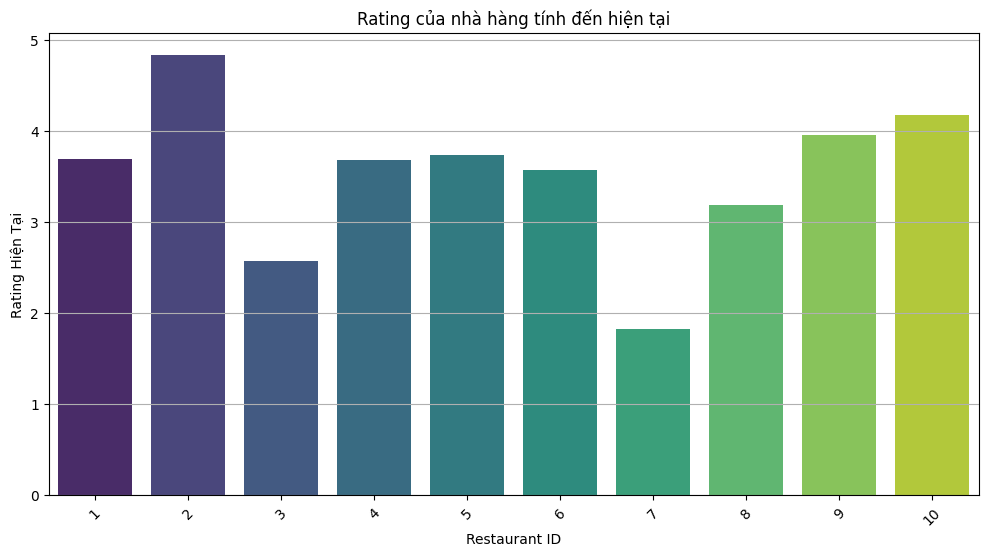

In [ ]:
#biểu đồ rating
plt.figure(figsize=(12, 6))
sns.barplot(x='restaurant_id', y='rating_hien_tai', data=result, palette='viridis')
plt.title('Rating của nhà hàng tính đến hiện tại')
plt.xlabel('Restaurant ID')
plt.ylabel('Rating Hiện Tại')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

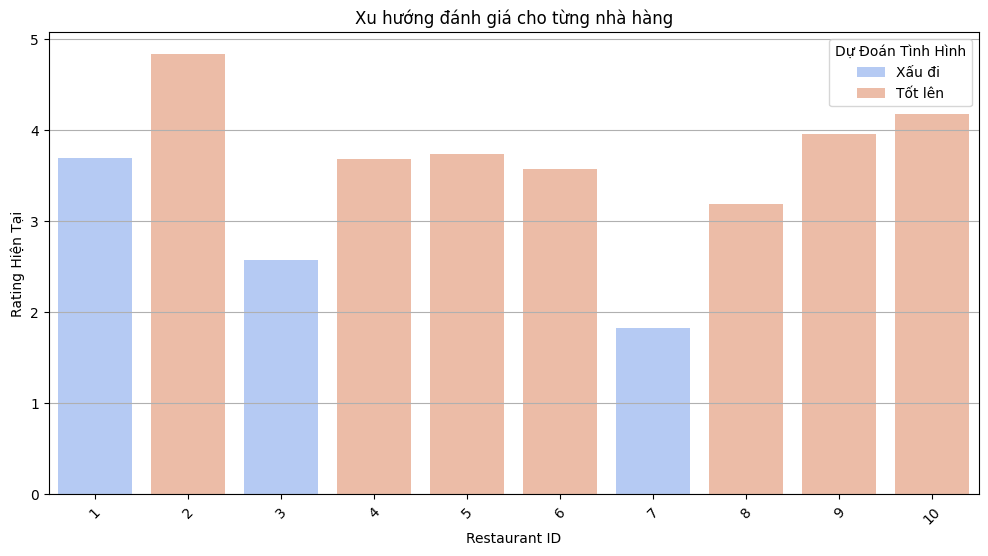

In [ ]:
# Biểu đồ dự đoán tình hình
plt.figure(figsize=(12, 6))
sns.barplot(x='restaurant_id', y='rating_hien_tai', hue='du_doan_tinh_hinh', data=result, palette='coolwarm')
plt.title('Xu hướng đánh giá cho từng nhà hàng')
plt.xlabel('Restaurant ID')
plt.ylabel('Rating Hiện Tại')
plt.xticks(rotation=45)
plt.legend(title='Dự Đoán Tình Hình')
plt.grid(axis='y')
plt.show()


Nhập ID nhà hàng bạn muốn xem: 1


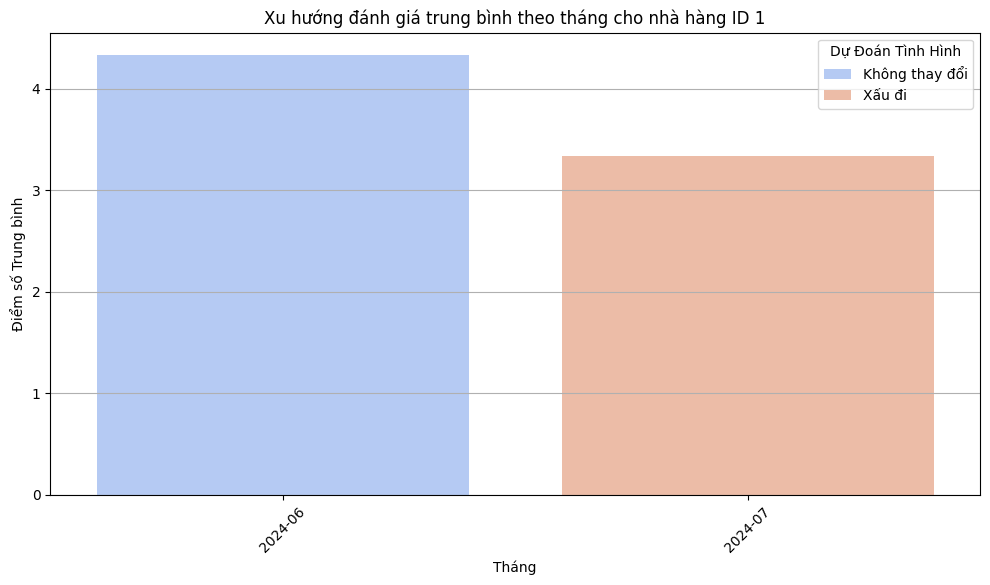

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Lọc dữ liệu cho tất cả các restaurant_id
data_filtered = data_sorted

# Tính khoảng cách thời gian, trọng số và trung bình có trọng số như trước
data_filtered['days_since_review'] = (current_date - data_filtered['review_date']).dt.days
data_filtered['weight'] = 1 / (data_filtered['days_since_review'] + 1)

# Tính trung bình có trọng số của số sao cho từng nhà hàng
weighted_avg_ratings = data_filtered.groupby('restaurant_id').apply(
    lambda x: (x['rating'] * x['weight']).sum() / x['weight'].sum()
).reset_index()
weighted_avg_ratings.columns = ['restaurant_id', 'rating_hien_tai']

# Tính xu hướng cho từng nhà hàng
trend_predictions = data_filtered.groupby('restaurant_id').apply(compute_trend).reset_index()
trend_predictions.columns = ['restaurant_id', 'du_doan_tinh_hinh']

# Kết hợp dữ liệu trung bình có trọng số và xu hướng
result = pd.merge(weighted_avg_ratings, trend_predictions, on='restaurant_id')

# Thêm cột tháng cho dữ liệu
data_filtered['month'] = data_filtered['review_date'].dt.to_period('M')

# Tính trung bình theo từng tháng cho từng nhà hàng
monthly_avg = data_filtered.groupby(['restaurant_id', 'month'])['rating'].mean().reset_index()
monthly_avg.columns = ['restaurant_id', 'month', 'average_rating']

# Tính toán sự thay đổi giữa các tháng
monthly_avg['previous_avg'] = monthly_avg.groupby('restaurant_id')['average_rating'].shift(1)
monthly_avg['trend'] = monthly_avg['average_rating'] - monthly_avg['previous_avg']

# Phân loại xu hướng
monthly_avg['du_doan_tinh_hinh'] = monthly_avg['trend'].apply(
    lambda x: 'Tốt hơn' if x > 0 else ('Xấu đi' if x < 0 else 'Không thay đổi')
)

# Nhập vào ID nhà hàng từ người dùng
restaurant_id = int(input("Nhập ID nhà hàng bạn muốn xem: "))

# Lọc ra dữ liệu cho nhà hàng cụ thể
trend_result = monthly_avg[monthly_avg['restaurant_id'] == restaurant_id]

# Kiểm tra nếu không có dữ liệu cho nhà hàng đó
if trend_result.empty:
    print(f"Không có dữ liệu cho nhà hàng với ID {restaurant_id}.")
else:
    # Vẽ biểu đồ so sánh điểm số trung bình theo thời gian
    plt.figure(figsize=(12, 6))
    sns.barplot(x='month', y='average_rating', hue='du_doan_tinh_hinh', data=trend_result, palette='coolwarm')
    plt.title(f'Xu hướng đánh giá trung bình theo tháng cho nhà hàng ID {restaurant_id}')
    plt.xlabel('Tháng')
    plt.ylabel('Điểm số Trung bình')
    plt.xticks(rotation=45)
    plt.legend(title='Dự Đoán Tình Hình')
    plt.grid(axis='y')
    plt.show()
